In [19]:
from gensim.models import Doc2Vec
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
import numpy as np  
import sys
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

import operator
import heapq
import re

import pandas as pd
import random as rnd
from random import shuffle

from twitch import commons

%pylab inline
matplotlib.use('Agg')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
docvec_ids = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')][0:100]\
            + [line.strip().split(',')[0] for line in open('../male_channels.csv', 'r')][0:100]
print(len(docvec_ids))

200


In [4]:
df_list = []
female_channels = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')]
male_channels = [line.strip().split(',')[0] for line in open('../male_channels.csv', 'r')]
for docvec_id in docvec_ids:
    channel = docvec_id
    if channel in female_channels:
        channel_type = 1
        channel_rank = female_channels.index(channel)
        quartile = (channel_rank//50) + 1
        if channel_rank < 100:
            color=1
        else:
            color=2
    else :
        channel_type = 0
        channel_rank = male_channels.index(channel)
        quartile = (channel_rank//50) + 1
        if channel_rank < 100:
            color=3
        else:
            color=4
        
    df_list.append((docvec_id, channel, channel_type, channel_rank, quartile, color)) 

print(len(df_list))

200


In [5]:
shuffle(df_list)
channel_df = pd.DataFrame(df_list, columns=['docvec_index', 'channel', 'gender', 'channel_rank', 'quartile', 'color'])

gender_list = channel_df.gender.values.tolist()
quartile_list = channel_df.quartile.values.tolist()
color_list =channel_df.color.values.tolist()
rank_list = channel_df.channel_rank.values.tolist()

In [6]:
model = Doc2Vec.load('./channel_all_chats.d2v')

In [7]:
non_normalized_feature_vectors = [model.docvecs[x] for x in channel_df.docvec_index.values.tolist()]

feature_vectors = preprocessing.normalize(preprocessing.scale(non_normalized_feature_vectors))

In [8]:
no_of_channels = len(feature_vectors)
print(no_of_channels)

200


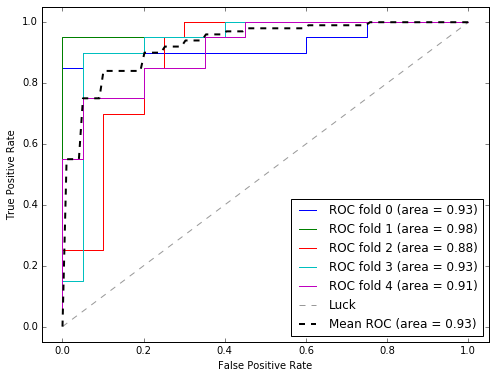

Accuracy: 0.86 (+/- 0.10)


In [9]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

y = np.array(gender_list)
(lr, coef, _) = commons.build_lr_classification_model_cv(feature_vectors, y, 5)

In [10]:
all_words_dic = commons.read_word_count_file("../../data/word_counts/global_word_counts.csv")
all_words_list = sorted(all_words_dic.items(), key=operator.itemgetter(1), reverse=True)

selected_word_vectors = []
selected_words = []
count = 0
for w in all_words_list:
    if count < 100000:
        try:
            selected_word_vectors.append(model[w[0]])
            selected_words.append(w)
            count += 1
        except:
            continue
    else:
        break
selected_word_vectors = preprocessing.normalize(preprocessing.scale(selected_word_vectors))

word_similarity_dic = {}
for i,w in enumerate(selected_words):
    try:
        word_similarity_dic[w[0]] = lr.predict_proba(selected_word_vectors[i].reshape(1, -1))[0][1]
    except:
        continue
        
top_female_words = heapq.nlargest(25, word_similarity_dic, key=word_similarity_dic.get)
print(', '.join(top_female_words))

print('')

top_male_words = heapq.nsmallest(25, word_similarity_dic, key=word_similarity_dic.get)
print(', '.join(top_male_words))

marry, babe, boobs, boobies, lovely, sweety, smile, tsb, beatiful, bewbs, cute, gorgeous, beautiful, hihi, reaaly, youu, kawaii, youuu, diyom, scarlett, cryyy, tits, dress, girll, kisses

nokappa, magnitude, thatnks, wavedash, poliwrath, thiefs, mousekeys, revolving, kayak, talos, boatysnake, fireballs, plunder, fragurn, ethiopian, consistent, clipboard, shitbag, utopia, iconcry, spotting, syria, redmercy, mechjeb, tailored


In [11]:
female_channels = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')][0:100]
male_channels = [line.strip().split(',')[0] for line in open('../male_channels.csv', 'r')][0:100]

In [12]:
channel_chat_log = []
for female in female_channels:
    message = []
    with open('../../data/channel_chat_logs/cleaned/' + female + "_chat_log.csv") as f:
        for line in f:
            splits = line.split(',')
            message.append(splits[3])
    channel_chat_log.append(' '.join(message))

In [13]:
for male in male_channels:
    message = []
    with open('../../data/channel_chat_logs/cleaned/' + male + "_chat_log.csv") as f:
        for line in f:
            splits = line.split(',')
            message.append(splits[3])
    channel_chat_log.append(' '.join(message))

In [16]:
cleaned_channel_log = []
gendered_terms = ['\bhe\b', r'\bhes', r'\bshe\b', r'\bshes\b', r'\bhis\b', r'\bher\b', r'\bbro\b',
                  r'\bman\b', r'\bsir\b', r'\bdude\b', r'\bgirl\b', r'\bgirls\b', r'\blady\b',
                  r'\bgurl\b', r'\bhers\b', r'\bhisself\b', r'\bherself\b', r'\bman\b', r'\bwoman\b']
for channel_log in channel_chat_log:
    for temp in gendered_terms:
        channel_log = re.sub(temp, '', channel_log)
    cleaned_channel_log.append(channel_log)

In [17]:
target_y = np.concatenate((np.ones(100), np.zeros(100)), axis=0)

In [20]:
tf = TfidfVectorizer(analyzer='word', max_features=100000, stop_words = 'english')

In [21]:
x = tf.fit_transform(cleaned_channel_log)

In [22]:
x = preprocessing.normalize(x)
feature_names = tf.get_feature_names() 

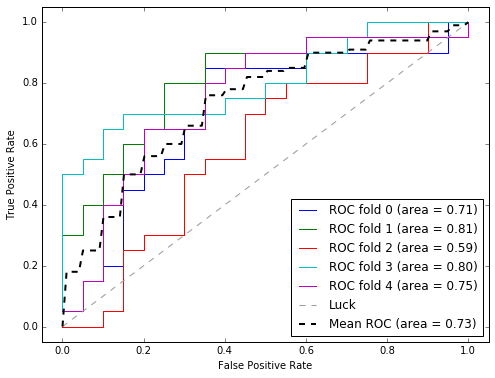

Accuracy: 0.66 (+/- 0.07)


In [23]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

clf,coef,_ = commons.build_lr_classification_model_cv(x, target_y, 5)

In [24]:
print('Female words : ' + ', '.join([feature_names[i] for i in coef[0].argsort()[-25:][::-1]]))
print('')
print('Male words : ' + ', '.join([feature_names[i] for i in (- coef[0]).argsort()[-25:][::-1]]))

Female words : hi, raffle, boobs, im, purrpoints, song, lmp, love, beemes, koalibubbles, smih, sheever, alisha, emily, que, lowco, hello, yuuie, michi, cin, poli, sonyapower, lacehype, sovi, renaysolo

Male words : chris, coty, deepcoins, uec, valkrin, frankerz, slin, boogie, panik, carryme, timmac, thenicelab, hutch, crumpets, wizz, pobelter, circon, strengthhype, aeikcoins, abdou, dabs, zionspartan, diemhype, cab, brooks
